# Open Data From JSON

In [57]:
import pandas as pd
import numpy as np
import glob

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...


# Preprocessing 

In [59]:
import re

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-60-e19db8f3f081>:3: DeprecationWarning: invalid escape sequence \.
  df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))


In [61]:
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)

for element in df["tokenized_words"]:
        	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

df["maintext_nouns"] = nouns

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,maintext_prepro,tokenized_words,maintext_nouns
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...,neighbors » forums » sports news » denver bron...,"[Neighbors, », Forums, », Sports, News, », Den...",Neighbors Forums Sports News Denver Broncos Fo...
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...,art historian kelly grovier looks at images t...,"[Art, historian, Kelly, Grovier, looks, at, im...",Art historian Kelly Grovier image frame trompe...


# Word Cloud

In [64]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Word Cloud All Words

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


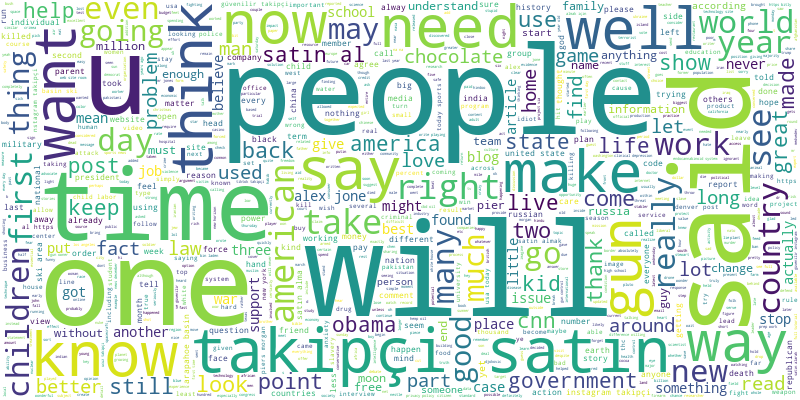

In [65]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


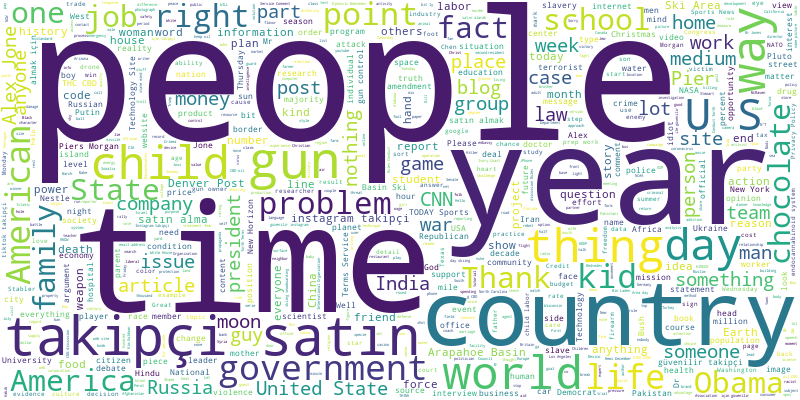

In [66]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

In [67]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'http', 'https'])  #extend stopwords if desired

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

df["maintext_ready"] = remove_stopwords(df["maintext_ready"].tolist())

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, artic..."
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...,neighbors » forums » sports news » denver bron...,"[Neighbors, », Forums, », Sports, News, », Den...",Neighbors Forums Sports News Denver Broncos Fo...,"[neighbors, forums, sports, news, denver, bron..."
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...,art historian kelly grovier looks at images t...,"[Art, historian, Kelly, Grovier, looks, at, im...",Art historian Kelly Grovier image frame trompe...,"[art, historian, kelly, grovier, image, frame,..."


In [73]:
# Create the Corpus

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
import gensim.corpora as corpora

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, artic...","[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...,neighbors » forums » sports news » denver bron...,"[Neighbors, », Forums, », Sports, News, », Den...",Neighbors Forums Sports News Denver Broncos Fo...,"[neighbors, forums, sports, news, denver, bron...","[(3, 1), (4, 1), (6, 1), (11, 1), (12, 1), (18..."
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...,art historian kelly grovier looks at images t...,"[Art, historian, Kelly, Grovier, looks, at, im...",Art historian Kelly Grovier image frame trompe...,"[art, historian, kelly, grovier, image, frame,...","[(48, 1), (49, 1), (50, 1), (51, 1), (52, 2), ..."


# Build a LDA model (need to find fitting values here)

In [77]:
from pprint import pprint   #pretty printing

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
amount_of_topics = 10   #adjust to find good results

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics)   #build the LDA model

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Displaying the LDA model

In [94]:
pprint(lda_model.print_topics())
articles_lda = lda_model[corpus]

[(0,
  '0.012*"people" + 0.009*"gun" + 0.005*"year" + 0.005*"time" + 0.005*"jones" '
  '+ 0.004*"alex" + 0.004*"country" + 0.004*"way" + 0.004*"world" + '
  '0.003*"takipci"'),
 (1,
  '0.008*"people" + 0.005*"time" + 0.004*"country" + 0.004*"child" + '
  '0.004*"year" + 0.003*"way" + 0.003*"gun" + 0.003*"chocolate" + '
  '0.003*"takipci" + 0.003*"world"'),
 (2,
  '0.010*"people" + 0.005*"time" + 0.005*"takipci" + 0.004*"year" + '
  '0.004*"satın" + 0.004*"world" + 0.003*"day" + 0.003*"obama" + '
  '0.003*"country" + 0.003*"child"'),
 (3,
  '0.006*"people" + 0.005*"child" + 0.005*"takipci" + 0.005*"gun" + '
  '0.005*"country" + 0.004*"time" + 0.004*"year" + 0.003*"satın" + '
  '0.003*"thing" + 0.003*"way"'),
 (4,
  '0.007*"people" + 0.007*"gun" + 0.005*"takipci" + 0.005*"satın" + '
  '0.005*"year" + 0.005*"time" + 0.004*"child" + 0.004*"jones" + '
  '0.004*"country" + 0.003*"way"'),
 (5,
  '0.008*"satın" + 0.008*"people" + 0.008*"takipci" + 0.006*"time" + '
  '0.005*"gun" + 0.004*"child

# Visualize the LDA model for further analysis (needed to find the best values to adjust)

In [95]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from IPython.display import HTML, display

pyLDAvis.enable_notebook()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.006133 -0.007939       1        1  26.650753
9     -0.031107  0.006424       2        1  13.684084
7      0.002594  0.015310       3        1  13.385489
6      0.012081 -0.006682       4        1  13.181238
5      0.016497  0.009773       5        1  12.292128
2      0.004384 -0.000459       6        1   5.990887
4      0.004922  0.002820       7        1   4.604619
8     -0.006133 -0.016624       8        1   4.174062
1      0.006256 -0.009538       9        1   3.316959
3     -0.003361  0.006914      10        1   2.719781, topic_info=            Term        Freq       Total Category  logprob  loglift
297       people  959.000000  959.000000  Default  30.0000  30.0000
2025         gun  579.000000  579.000000  Default  29.0000  29.0000
14697    takipci  500.000000  500.000000  Default  28.0000  28.0000
440         time  587.000000  587.000000  Default  27.0000  27.0000
375        child  403.000000  403.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
40          news    7.081983  265.532735  Topic10  -6.0433  -0.0196
253         home    5.942531  186.318880  Topic10  -6.2187   0.1593
2179   instagram    6.309244  224.639921  Topic10  -6.1589   0.0321
171        world    7.859542  396.222562  Topic10  -5.9391  -0.3156
303         post    6.195939  294.370035  Topic10  -6.1770  -0.2563

[797 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
3478       1  0.100930  acceptance
3478       2  0.100930  acceptance
3478       3  0.100930  acceptance
3478       4  0.403718  acceptance
3478       5  0.100930  acceptance
...      ...       ...         ...
10484      4  0.157902      yougov
10484      5  0.315804      yougov
10484      6  0.157902      yougov
10484      7  0.157902      yougov
173        3  0.593568         œil

[2400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 8, 7, 6, 3, 5, 9, 2, 4])